In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using Distributions 
using IntervalSets
using BAT

using HCubature
using JLD
using CPUTime

using Plots
using Colors
using ColorSchemes
using LaTeXStrings

using SpecialFunctions

pyplot(size=(750,500))
line_colors = ColorSchemes.tab20b;

# Generate Distribution: 

In [ ]:
# data = hcat(randn(1000), randn(1000))

# sx, sy = 0.12, 0.15

# Scale = [sx 0; 0 sy]

# theta = 0.75*pi

# c, s = cos(theta), sin(theta)

# Rot = [c -s; s c]

# T = Scale * Rot

# data_p =(data * T)';

# sigma = cov(data_p')

# @show sigma

In [ ]:
# Correlated Normal:

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_2 = [0.15152028283087893 -0.11598742336072133; -0.11598742336072133 0.1616797732933265] #[0.1572026439007445 -0.1044956058704804; -0.1044956058704804 0.13445945463874312] 
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -50
max_v = 50
lgV = N*log(max_v-min_v); 

g(x;μ=[0, 0], sigma=sigma) = pdf(MvNormal(μ, sigma), x)

f(x) = g(x, μ=[5, 5], sigma=sigma_1) + g(x, μ=[-5, -5], sigma=sigma_1) + 0.1*g(x, μ=[5, -5], sigma=sigma_3) + 0.9*g(x, μ=[-5, 5], sigma=sigma_2)

In [ ]:
# Normal Distribution

true_param =(μ1=0, μ2=-1, σ=1)
min_v = -8
max_v = 8
N = 4
lgV = N*log(max_v-min_v); 


function f(x::AbstractArray; true_param=true_param)
    tmp = prod(pdf.(Normal(true_param.μ1, true_param.σ), x))
    return tmp
end

In [2]:
#Report distribution

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -20
max_v = 20
lgV = N*log(max_v-min_v); 

g(x;μ=[0, 0], sigma=sigma_1) = pdf(MvNormal(μ, sigma), x)

f(x) = (1/2.08)*(g(x, μ=[3.5, 3.5], sigma=sigma_1) + g(x, μ=[-3.5, -3.5], sigma=sigma_1) + 0.04*g(x, μ=[3.5, -3.5], sigma=sigma_3) + 0.04*g(x, μ=[-3.5, 3.5], sigma=sigma_3))

f (generic function with 1 method)

## Plot Distribution: 

levels = [1.1121900092013422e-21, 0.0035844719884968635, 0.031007392601642293, 0.24449572536727365, 0.2728666433966312]


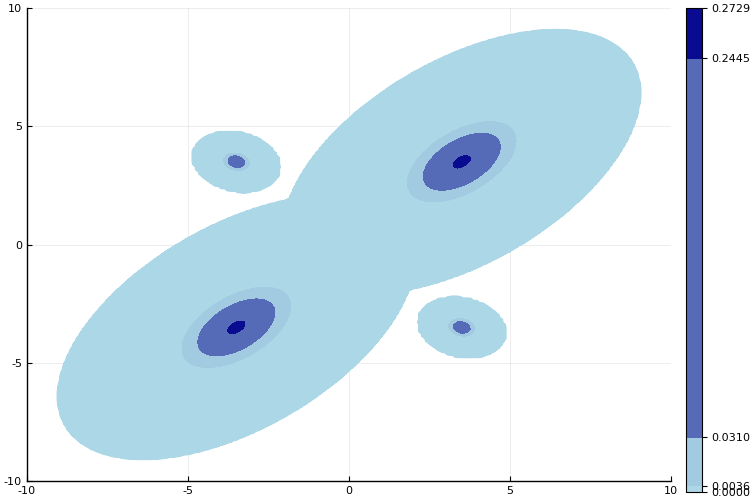

In [3]:
x_range = range(-10, stop=10, length=200)
y_range = range(-10, stop=10, length=200)

z = [f([i,j]) for i in x_range, j in y_range]';

levels_quantiles = [0.6, 0.96, 0.98, 0.999, 1,]
levels=quantile([z...], levels_quantiles)

@show levels

contour(x_range, y_range, z; fill=true, levels=levels, fillalpha=0.2, color=:blues)

# Generate MCMC Samples: 

In [4]:
algorithm = MetropolisHastings()

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.1,
    c = 1e-4..1e2
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 8..128,
    max_nsamples_init = 50,
    max_nsteps_init = 50,
    max_time_init = 18
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 10,
    max_nsteps_per_cycle = 100,
    max_time_per_cycle = 25,
    max_ncycles = 1
)

HMI_Manual_Settings = BAT.HMISettings(BAT.cholesky_partial_whitening!, 
        1000, 
        1.5, 
        0.1, 
        true, 
        16, 
        true, 
        Dict("cov. weighted result" => BAT.hm_combineresults_covweighted!)
    )

log_likelihood = params -> LogDVal((log(f(params.a))))

prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],)

posterior = PosteriorDensity(log_likelihood, prior);

In [5]:
nchains = 2
nsamples = 1*10^5
max_time = 150
max_nsteps = 10 * nsamples;

In [6]:
samples, stats = bat_sample(posterior, (nsamples, nchains), MetropolisHastings(), tuning=tuning, init=init, burnin=burnin);

┌ Info: Trying to generate 2 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 2 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 2 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 2 chains, 0 tuned, 2 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Warning: MCMC tuning of 2 chains aborted after 1 cycle(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:115


In [7]:
hmi_data = BAT.HMIData(unshaped.(samples))
ahmi_ex_time = @CPUelapsed BAT.hm_integrate!(hmi_data)

ahmi_integral_run =[hmi_data.integralestimates["cov. weighted result"].final.estimate, hmi_data.integralestimates["cov. weighted result"].final.uncertainty]
log_smpl_int = log.(ahmi_integral_run) .+ lgV

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	33022 / 33021	Parameters:	2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT

2-element Array{Float64,1}:
  0.019649310013879706
 -4.848374309027753

In [8]:
integral = exp.(log_smpl_int)

2-element Array{Float64,1}:
 1.0198436283595977
 0.007841114422239464

┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::Histogram{Int64,2,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}, ::Tuple{Int64,Int64}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/vhafych/.julia/packages/Plots/NVH6y/src/pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::Histogram{Int64,2,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}, ::Tuple{Int64,Int64}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/vhafych/.julia/packages/Plots/NVH6y/src/pipeline.jl:15
┌ Warning: Attribute alias `color` detected in the user recipe defined f

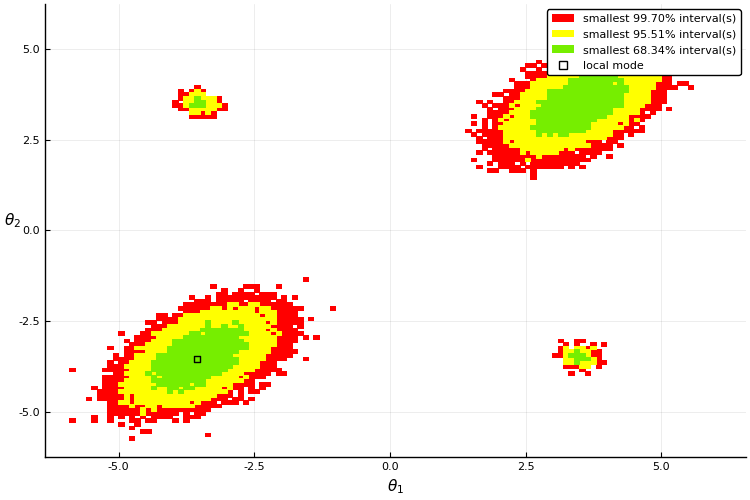

In [11]:
plot(samples, (1,2), legend=true,)